In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
file_name = 'smtcomp-unbit'
den = 1e3
source = 'gh'
time_to_save = 'assert'

if source == 'gh':
    data = pd.read_csv('final_data/' + file_name + '.csv', 
                       names=['exprId', 'repeatIdx', 'solver', 'status', 'checkTime', 'assertTime', 'roundCnt'])
    data['wocheckTime'] = data['assertTime'] - data['checkTime']

    if time_to_save == 'assert':
        data['time'] = data['assertTime']
    elif time_to_save == 'check':
        data['time'] = data['checkTime']
    elif time_to_save == 'wocheck':
        data['time'] = data['wocheckTime']
    else:
        raise Exception(":( time_to_save")
elif source == 'local':
    data = pd.read_csv('data/' + file_name + '.csv', 
                       names=['exprId', 'repeatIdx', 'solver', 'status', 'time', 'roundCnt'])
else:
    raise Exception(":( source")

data = data[data['roundCnt'] != -2]
# data = data[data['roundCnt'] == 1]
data['time'] = data['time'] / den
upper_bound = data['time'].max()
# data['time'] = data['time'].apply(lambda x : min(x, 3000_000_000 / den))
unknown_data = data[data['status'] == 'UNKNOWN']
# data.loc[unknown_data.index, 'time'] = upper_bound

maxExprId = data.groupby('solver').max()['exprId'].min()
# data = data[data['exprId'] <= maxExprId]
data_time = data[['exprId', 'solver', 'time', 'roundCnt', 'assertTime', 'checkTime', 'wocheckTime']].groupby(['exprId', 'solver']).mean()
data_time = data_time.reset_index().set_index('exprId')

solvers = data_time['solver'].drop_duplicates().to_list()

z3_names = list(filter(lambda x : 'Z3' in x, solvers))
cvc5_names = list(filter(lambda x : 'Cvc5' in x, solvers))
yices_names = list(filter(lambda x : 'Yices' in x, solvers))
others_names = list(filter(lambda x : 'Cvc5' not in x and 'Z3' not in x and 'Yices' not in x, solvers))

z3 = {name : data_time[data_time['solver'] == name]['time'] for name in z3_names}
cvc5 = {name : data_time[data_time['solver'] == name]['time'] for name in cvc5_names}
yices = {name : data_time[data_time['solver'] == name]['time'] for name in yices_names}
others = {name : data_time[data_time['solver'] == name]['time'] for name in others_names}

z3_cnt = {name : data_time[data_time['solver'] == name]['roundCnt'] for name in z3_names}
cvc5_cnt = {name : data_time[data_time['solver'] == name]['roundCnt'] for name in cvc5_names}
yices_cnt = {name : data_time[data_time['solver'] == name]['roundCnt'] for name in yices_names}
others_cnt = {name : data_time[data_time['solver'] == name]['roundCnt'] for name in others_names}

z3_all = {name : data_time[data_time['solver'] == name][['checkTime', 'assertTime', 'wocheckTime']] for name in z3_names}
cvc5_all = {name : data_time[data_time['solver'] == name][['checkTime', 'assertTime', 'wocheckTime']] for name in cvc5_names}
yices_all = {name : data_time[data_time['solver'] == name][['checkTime', 'assertTime', 'wocheckTime']] for name in yices_names}
others_all = {name : data_time[data_time['solver'] == name][['checkTime', 'assertTime', 'wocheckTime']] for name in others_names}

data.shape

(40332, 9)

In [4]:
# import importlib
# import util

# importlib.reload(util)

from util import *

config.init(data)
check(data)

(None, None)

In [5]:
def helper(solvers, f):
    for name, s in solvers.items():
        print(name, f(s).mean())
    print()

def print_mean_per_solver(solvers):
    if not solvers:
        return
    
    print('SAT')
    helper(solvers, get_sat_data)
        
    print('UNSAT')
    helper(solvers, get_unsat_data)
        
    print('OVERALL')
    helper(solvers, lambda x: x)

print_mean_per_solver(intersection(z3))
print_mean_per_solver(intersection(yices))

SAT
Z3 18516780.09008966
Z3-Eager-Sum-Signed 20288580.49192107
Z3-Eager-Sum-SignedLazyOverflow 19027785.609081957

UNSAT
Z3 14656526.58702699
Z3-Eager-Sum-Signed 7258630.499288293
Z3-Eager-Sum-SignedLazyOverflow 7425996.605390291

OVERALL
Z3 17534369.693061527
Z3-Eager-Sum-Signed 14541419.878526662
Z3-Eager-Sum-SignedLazyOverflow 14536323.454788567

SAT
Yices 14075918.147949759
Yices-Eager-Sum-Signed 20934065.562305354
Yices-Eager-Sum-SignedLazyOverflow-OriginalUnsat 15619958.931230444
Yices-Eager-Sum-Unsigned 20380870.204594165

UNSAT
Yices 2901484.2413975787
Yices-Eager-Sum-Signed 6272486.114024837
Yices-Eager-Sum-SignedLazyOverflow-OriginalUnsat 5002540.275042282
Yices-Eager-Sum-Unsigned 5353190.053125411

OVERALL
Yices 10575835.72922043
Yices-Eager-Sum-Signed 15051234.204022301
Yices-Eager-Sum-SignedLazyOverflow-OriginalUnsat 12233790.270881124
Yices-Eager-Sum-Unsigned 14162779.87663859



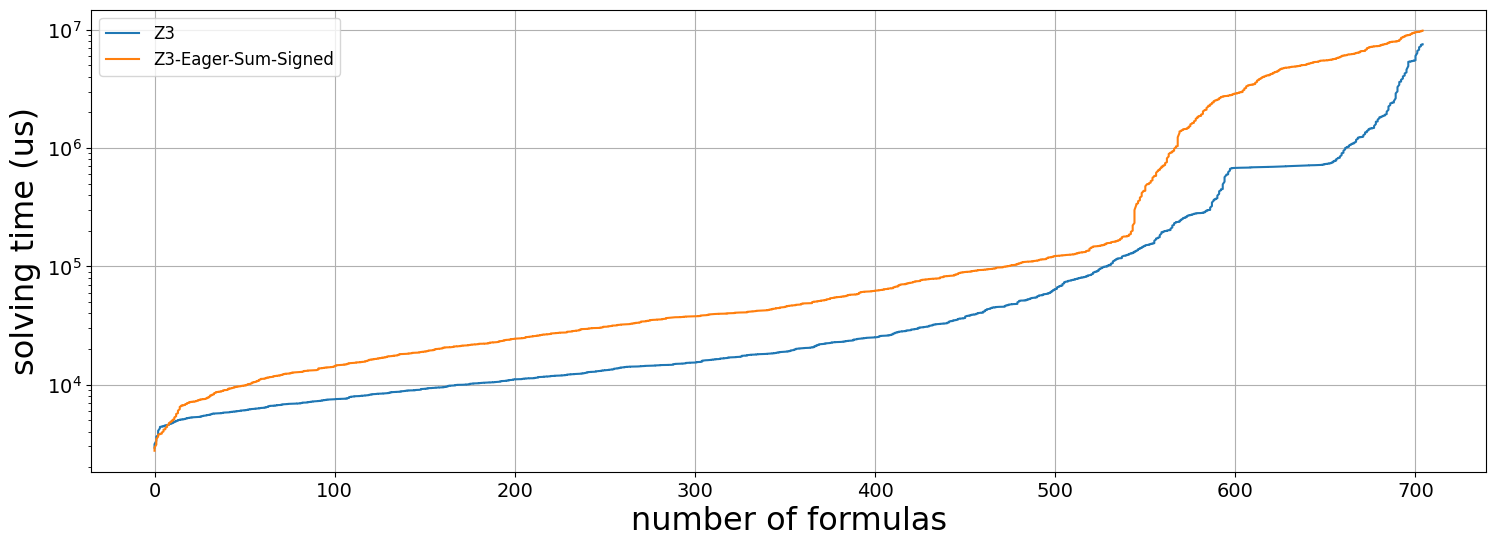

In [49]:
plot(intersection(tt), start=0.00, end=1.0, base=10)

In [44]:
yices_names

['Eager-Yices-Sum',
 'Eager-Yices-Sum-Signed',
 'Eager-Yices-Sum-SignedLazyOverflow-OriginalUnsat',
 'Yices']

In [47]:
z = {'original': yices['Yices'], 'rewritten': yices['Eager-Yices-Sum-Signed']}

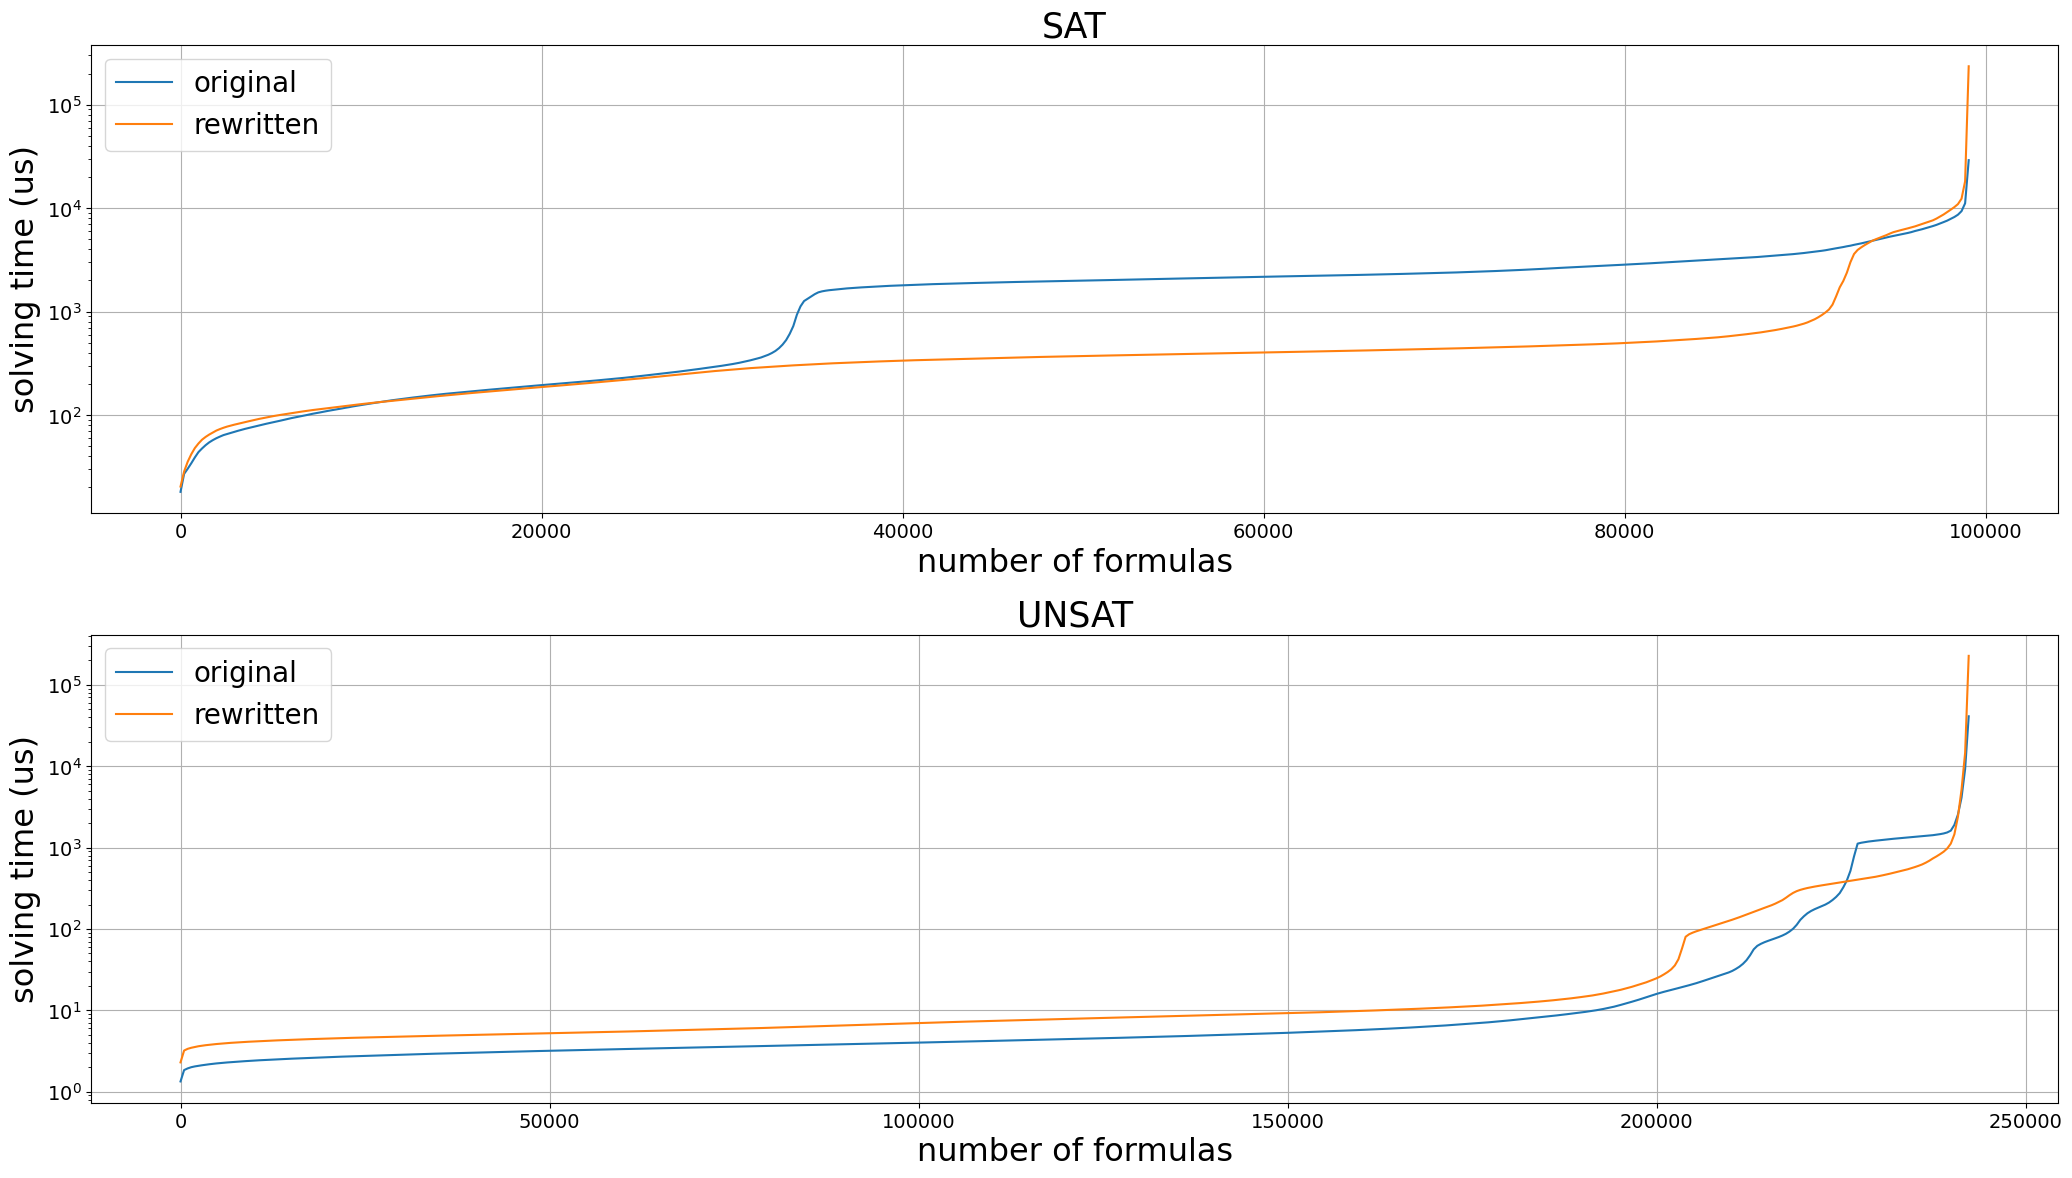

In [49]:
save_plot(z, 'final_plots/usvm-yices.png')

In [41]:
xx = yices['Yices']
yy = yices['Yices-Eager-Sum-Signed']

xx = xx[xx < 10 ** 7]
yy = yy[yy < 10 ** 7]

tt = { 'Z3': xx, 'Z3-Eager-Sum-Signed': yy }

In [42]:
tt = intersection(tt)

x = tt['Z3']
y = tt['Z3-Eager-Sum-Signed']

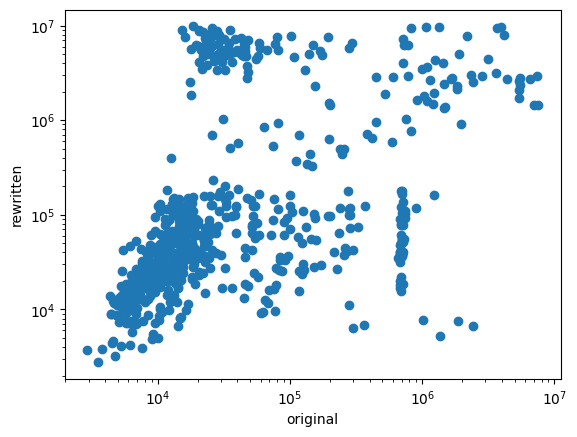

In [48]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(x, y)
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel("original")
plt.ylabel("rewritten")

plt.show()

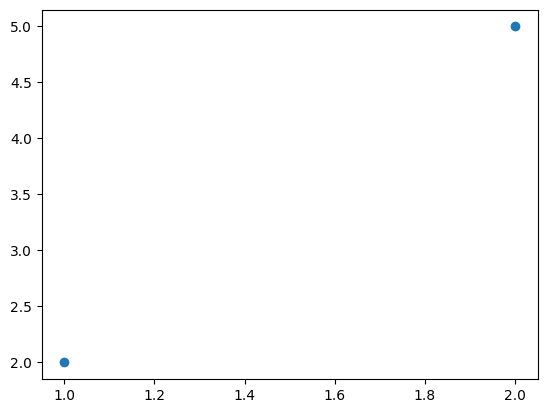

In [19]:
plt.scatter([1, 2], [2, 5])

In [48]:
data.drop_duplicates(['solver', 'exprId']).groupby('solver')['status'].apply(lambda x: (x == 'UNKNOWN').sum()).reset_index(name='count')

,solver,count
0,Yices,659
1,Yices-Eager-Sum-Signed,969
2,Yices-Eager-Sum-SignedLazyOverflow-OriginalUnsat,722
3,Yices-Eager-Sum-Unsigned,970
4,Z3-Eager-Sum-Signed,964
5,Z3-Eager-Sum-SignedLazyOverflow,932
6,Z3-Eager-Sum-Unsigned,1000


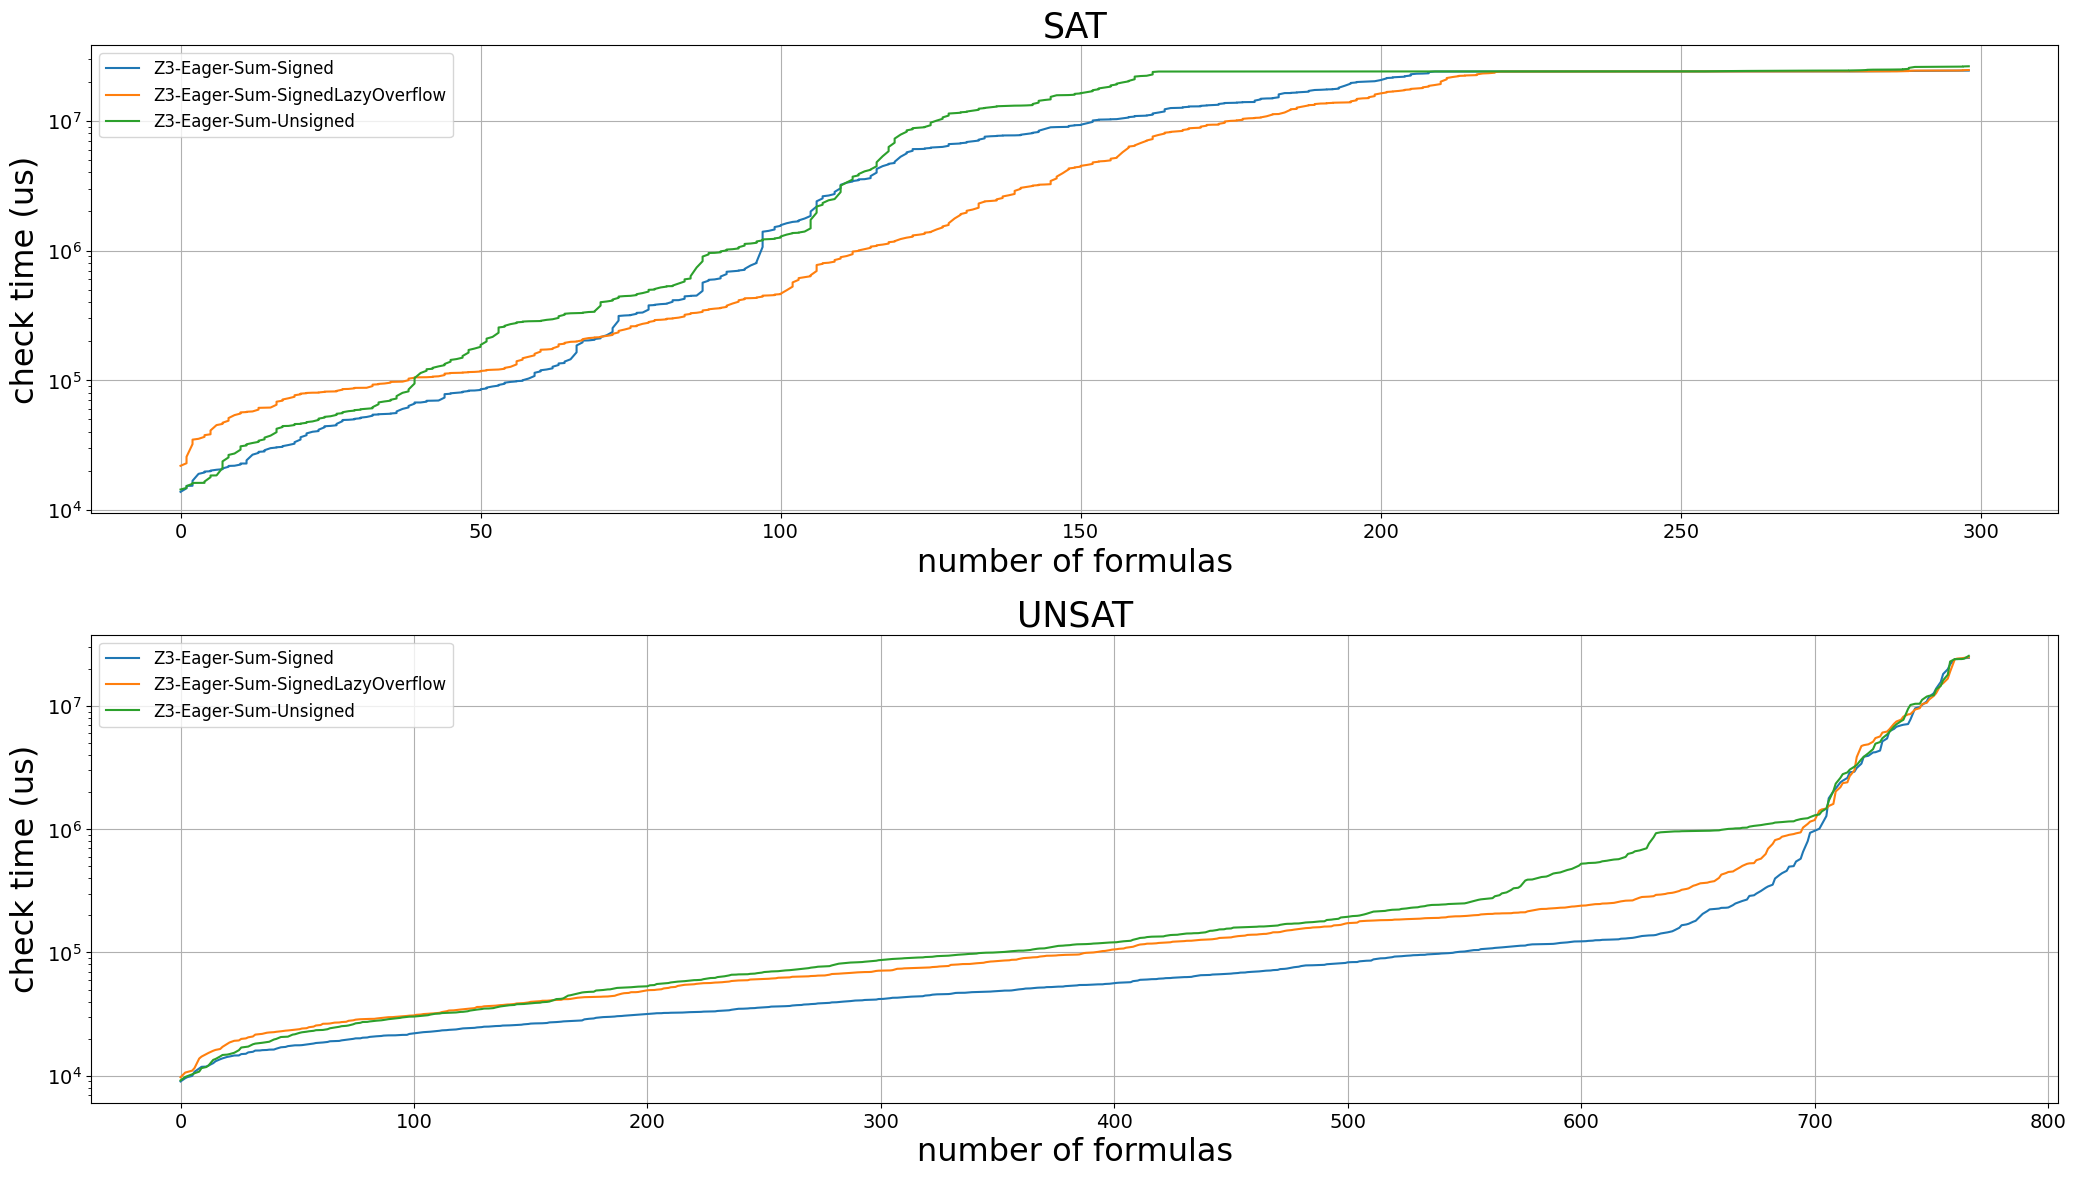

In [22]:
save_plot(z3, 'lol.png')

In [52]:
min([len(d.index) for d in intersection(cvc).values()]) 

2010

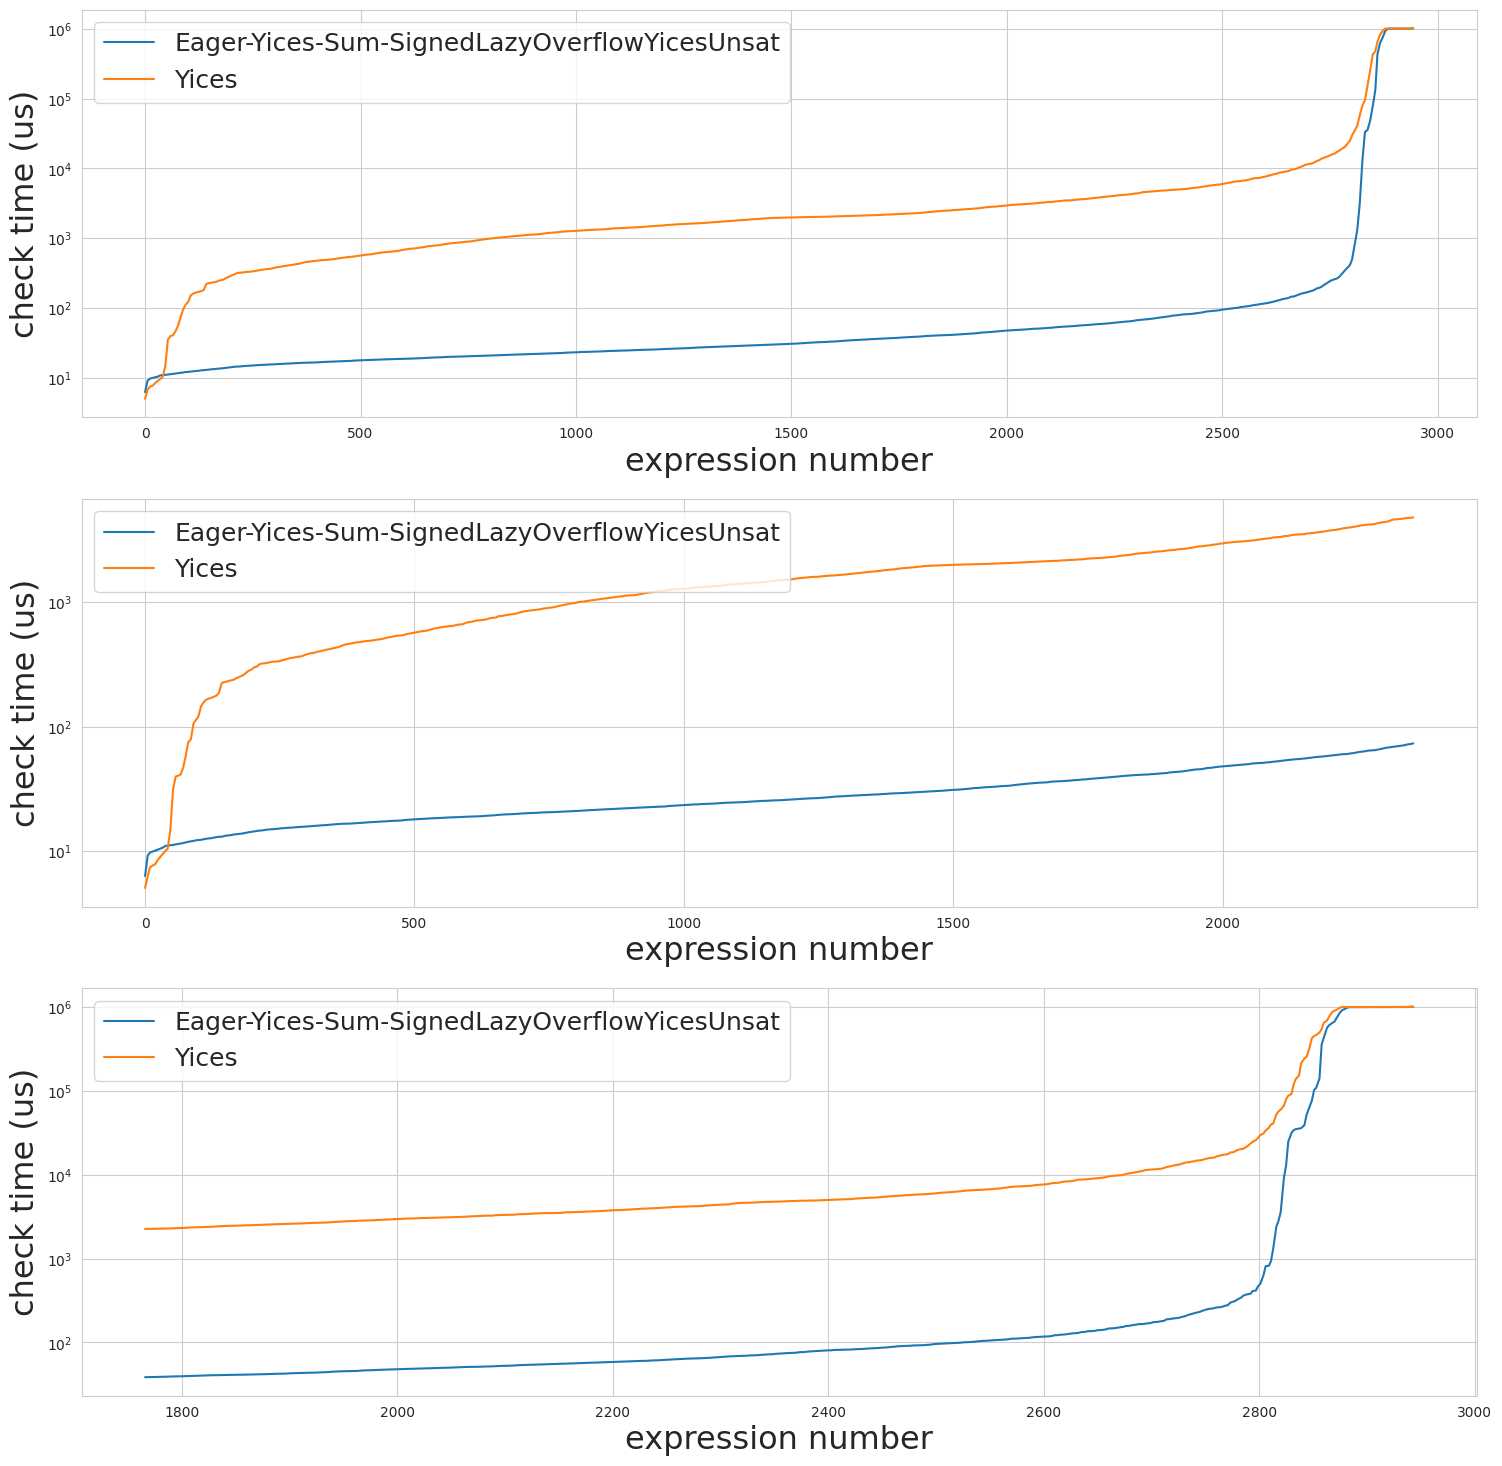

In [74]:
d = dict_filter(yices, lambda x: x == 'Yices' or 'YicesUnsat' in x or x == 'Eager-Yices-Sum-SignedLazyOverflow2')

sat_plot(d, 0.8, 0.6)

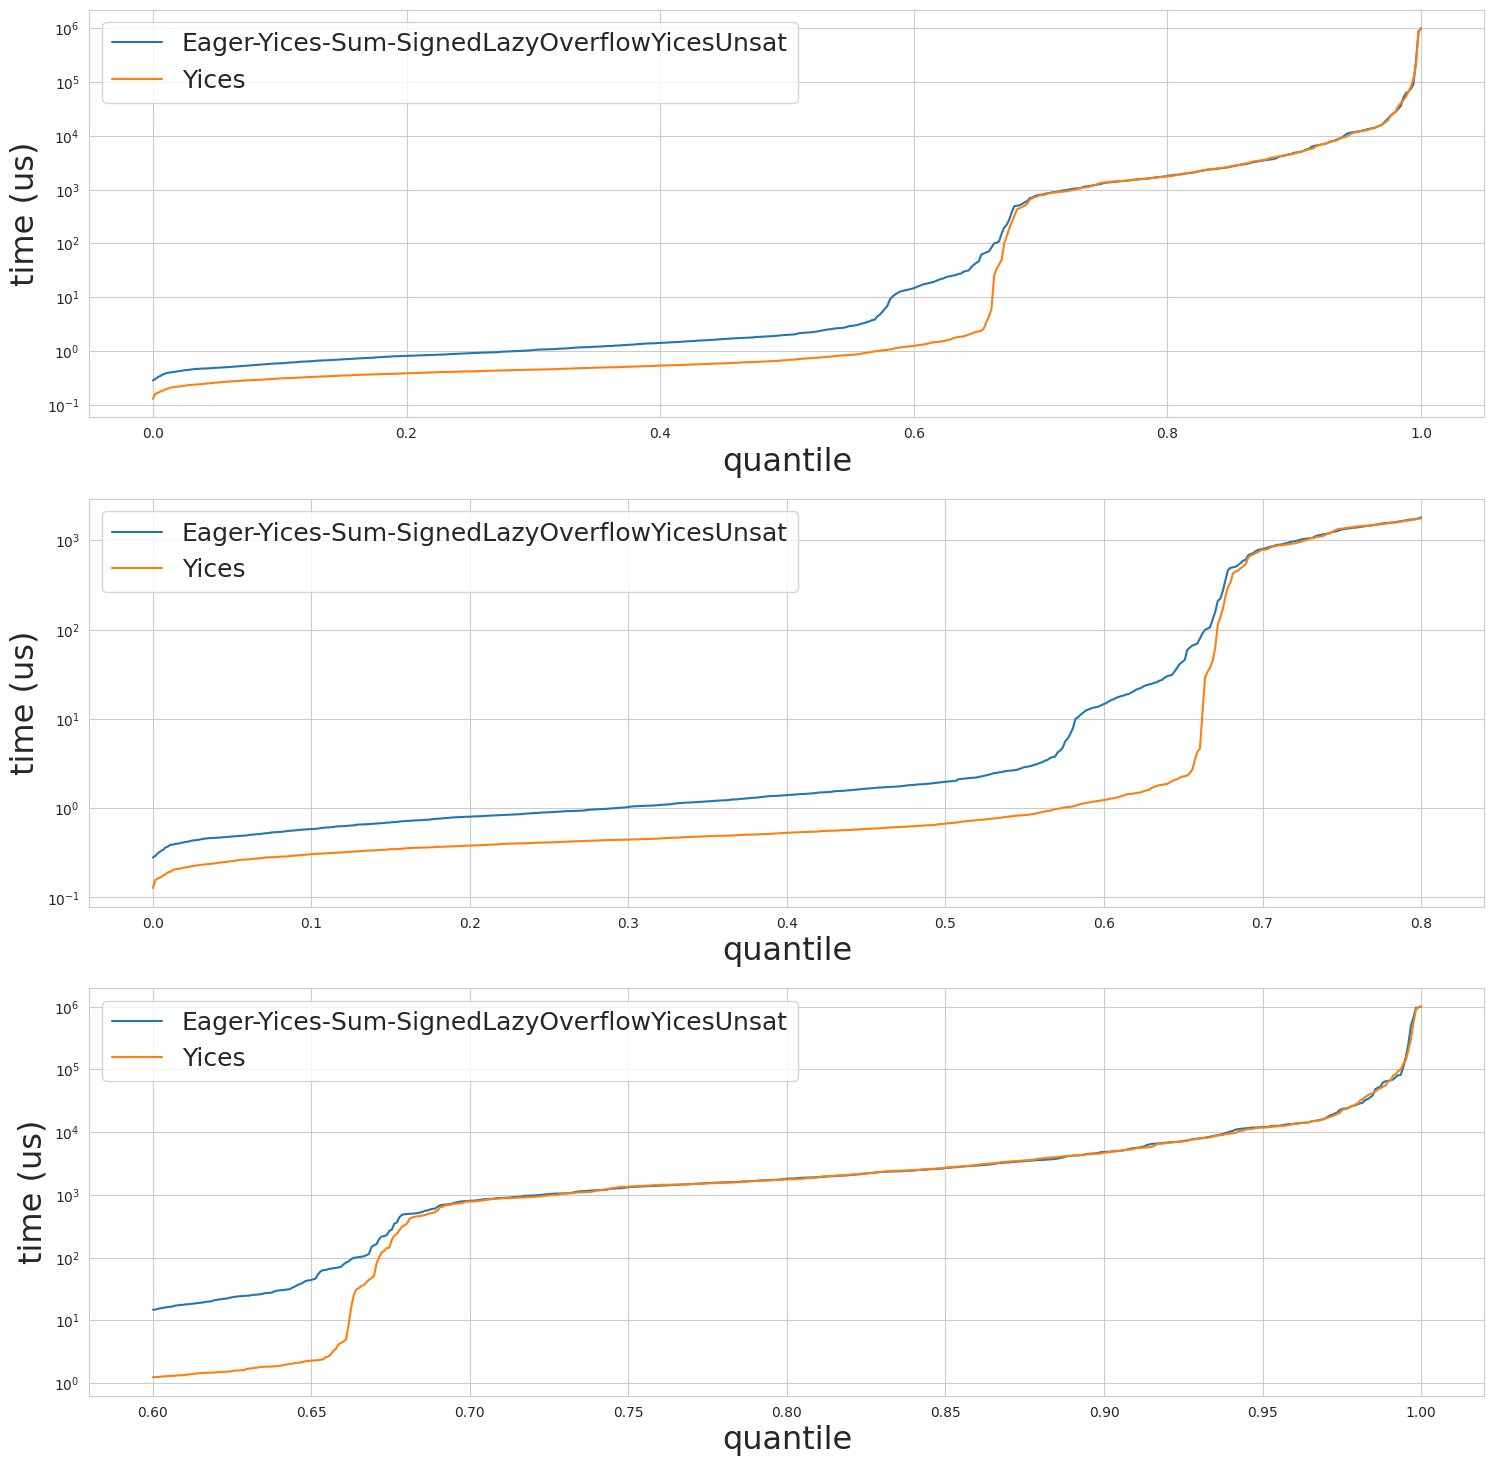

In [9]:
unsat_plot(d, 0.8, 0.6)

In [31]:
t = data[data['solver'] == 'Eager-Yices-Sum-SignedLazyOverflowYicesUnsat'].drop_duplicates('exprId').set_index('exprId')
t = t.loc[sat_idx, :]

In [38]:
t['roundCnt'] > 100

exprId
9        False
24       False
25       False
31       False
47       False
         ...  
7310      True
8109      True
8776      True
10358     True
12710     True
Name: roundCnt, Length: 2471, dtype: bool

In [21]:
sat_idx

Index([    9,    24,    25,    31,    47,    50,    51,    61,    62,    63,
       ...
        9518,  8918,   217,  2041,  5948,  7310,  8109,  8776, 10358, 12710],
      dtype='int64', name='exprId', length=2471)

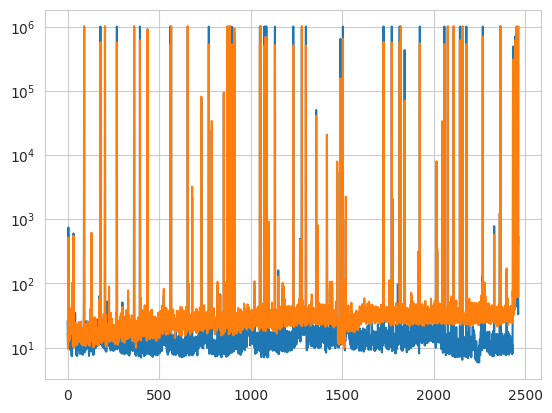

In [25]:
signed = get_sat_data(yices['Eager-Yices-Sum-SignedLazyOverflow2'])
mul = get_sat_data(yices['Eager-Yices-Sum-SignedLazyOverflowMulC2'])

plt.plot(np.arange(0, 2463), signed)
plt.plot(np.arange(0, 2463), mul)
plt.yscale('log', base=10)

plt.show()

In [16]:
unsat_stats(z3)

,mean,std,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,...,0.6,0.7,0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99
Eager-Z3-Sum,6.67,0.63,6.07,6.1,6.14,6.17,6.19,6.25,6.28,6.3,...,6.55,6.65,6.9,7.01,7.27,8.35,8.49,8.66,8.79,8.87
Eager-Z3-Sum-Signed,2000.0,0.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,...,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0
Eager-Z3-Sum-SignedNoOverflow,5.56,0.25,5.18,5.22,5.22,5.22,5.22,5.27,5.33,5.36,...,5.56,5.6,5.74,5.81,5.92,6.01,6.04,6.07,6.23,6.32
Z3,9.62,1.93,7.22,7.25,7.25,7.26,7.29,7.48,7.55,7.85,...,10.03,10.19,10.61,10.91,12.33,13.81,13.97,14.21,14.23,14.5


/home/pvl/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


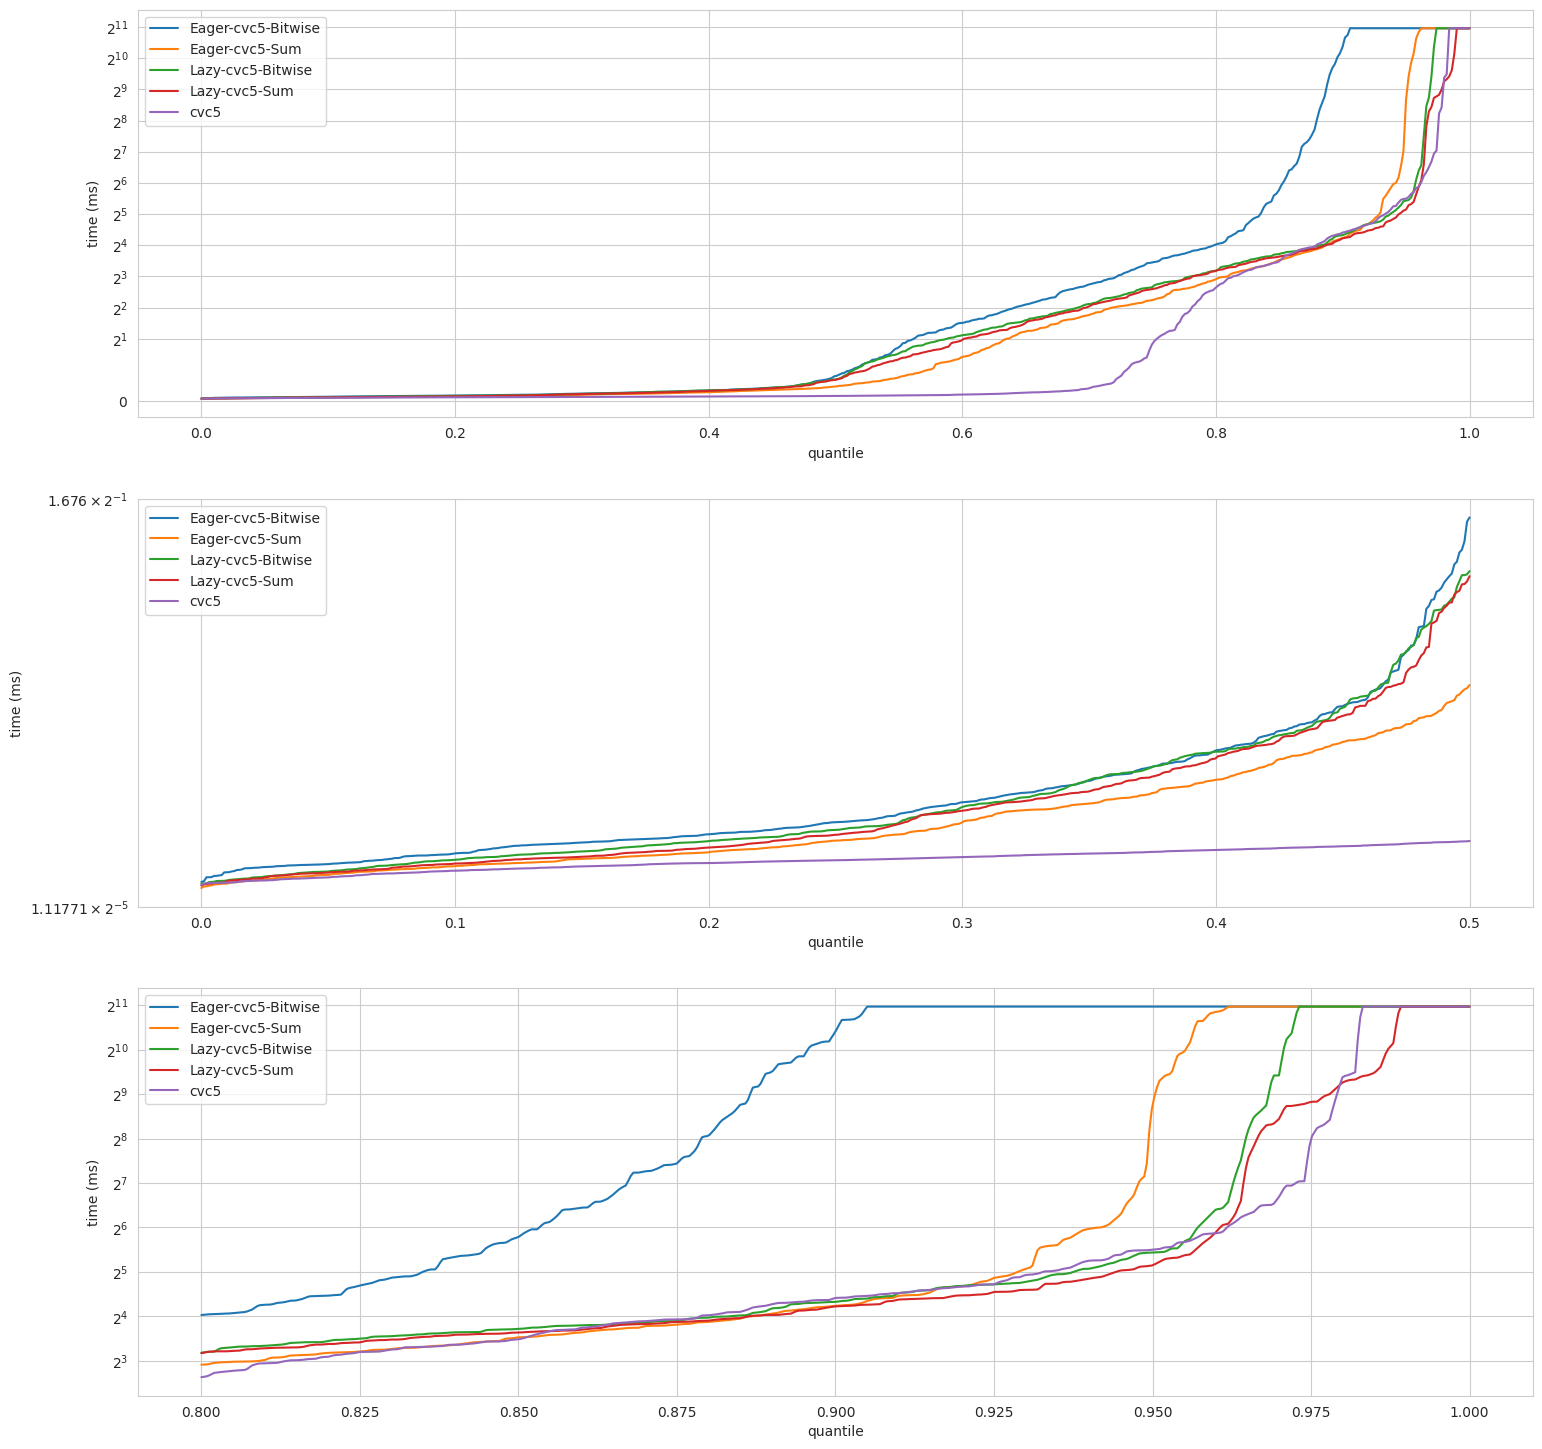

In [23]:
plot(cvc5, 0.5, 0.8)

In [9]:
data_status = data[['exprId', 'solver', 'status']].groupby(['exprId', 'solver', 'status']).count().reset_index()
z3_status = data_status[data_status['solver'] == 'Z3']
cvc5_status = data_status[data_status['solver'] == 'cvc5']
bv2int_z3_status = data_status[data_status['solver'] == 'Bv2Int-Z3']
bv2int_cvc5_status = data_status[data_status['solver'] == 'Bv2Int-cvc5']

print("UNKNOWN cnt\n")
print('Z3', (z3_status['status'] == 'UNKNOWN').sum())
print('cvc5', (cvc5_status['status'] == 'UNKNOWN').sum())
print('Bv2Int-Z3', (bv2int_z3_status['status'] == 'UNKNOWN').sum())
print('Bv2Int-cvc5', (bv2int_cvc5_status['status'] == 'UNKNOWN').sum())

UNKNOWN cnt

Z3 19
cvc5 0
Bv2Int-Z3 51
Bv2Int-cvc5 0


In [7]:
min_time = data_time.groupby('exprId').min()

print('min time cnt\n')

print('Z3', (z3 == min_time['time']).sum())
# print('cvc5', (cvc5 == min_time['time']).sum())
print('Bv2Int-Z3', (bv2int_z3 == min_time['time']).sum())
# print('Bv2Int-cvc5', (bv2int_cvc5 == min_time['time']).sum())

min time cnt


ValueError: Can only compare identically-labeled Series objects

In [29]:
hard_idx = (cvc5 > 300) | (bv2int_cvc5 > 300)

print(cvc5[hard_idx].mean())
print(bv2int_cvc5[hard_idx].mean())

1235.076518928788
815.0167222645456


In [34]:
hard_idx = (z3 > 20) | (bv2int_z3 > 20)

print(z3[hard_idx].mean())
print(bv2int_z3[hard_idx].mean())

376.1006704160524
550.4626932866503


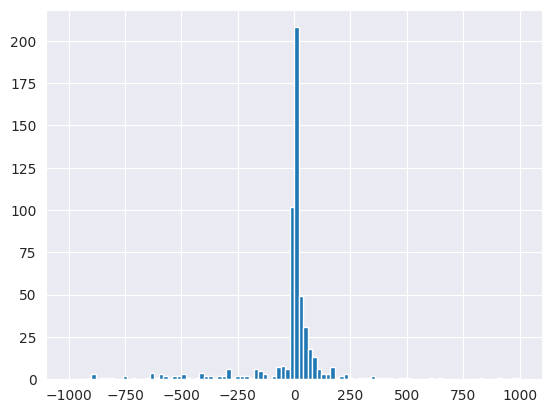

In [103]:
plt.hist((bv2int_cvc5['time'] -cvc5['time']), bins=100, range=(-1000, 1000))
plt.show()

<Axes: >

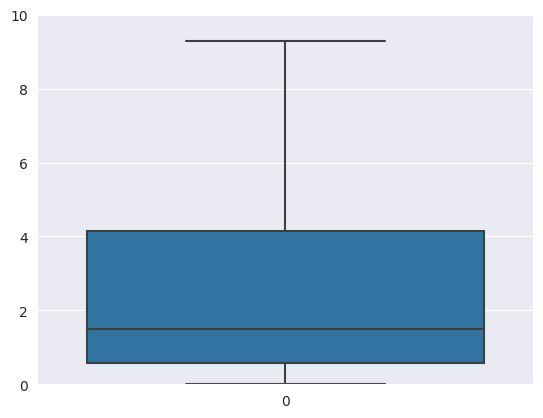

In [66]:
plt.ylim(0, 10)
sns.boxplot(bv2int_cvc5['time'] / cvc5['time'])